In [1]:
import os
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

import torch
import torch.nn as nn
import torch.nn.functional as F

import neurox.interpretation.utils as utils
import neurox.interpretation.ablation as ablation
import neurox.interpretation.linear_probe as linear_probe

from ttsxai.utils.utils import read_ljs_metadata

In [3]:
log_dir = '/nas/users/dahye/kw/tts/ttsxai/logs/probe_tacotron2_duration'
data_activation_dir = "/nas/users/dahye/kw/tts/ttsxai/data_activation/LJSpeech/tacotron2_waveglow"



# data..

In [43]:
def load_npz_file(file_path):
    data_dict = np.load(file_path, allow_pickle=True)
    phonesymbols = list(data_dict['phonesymbols'])
    durations = list(data_dict['duration'])
    articulatory_features = list(data_dict['articulatory_features'])
    activations = data_dict['activations'].item()
    return phonesymbols, durations, articulatory_features, activations

def load_npz_files(npz_files):
    tokens = {'source': [], 'target': [], 'articulatory_features': []}
    dict_activations = []
    for file in tqdm(npz_files):
        data_dict = np.load(file, allow_pickle=True)
        tokens['source'].append(list(data_dict['phonesymbols']))
        tokens['target'].append(list(data_dict['duration']))
        tokens['articulatory_features'].append(list(data_dict['articulatory_features']))
        dict_activations.append(data_dict['activations'].item())
    return tokens, dict_activations

def parallel_load_npz_files(npz_files, num_processes=None):
    if num_processes is None:
        num_processes = cpu_count()

    with Pool(num_processes) as pool:
        results = list(tqdm(pool.imap(load_npz_file, npz_files), total=len(npz_files)))

    tokens = {'source': [], 'target': [], 'articulatory_features': []}
    dict_activations = []
    for phonesymbols, durations, articulatory_features, activations in results:
        tokens['source'].append(phonesymbols)
        tokens['target'].append(durations)
        # meta data for used for filtering out
        tokens['articulatory_features'].append(articulatory_features)
        dict_activations.append(activations)
    return tokens, dict_activations

In [41]:
# Dictionary keys to filter
keys_to_filter = read_ljs_metadata(mode='train')

# List to store filtered paths
npz_files = []

# Iterate over all files in the directory
for file in os.listdir(data_activation_dir):
    # Check only for .npz files
    if file.endswith('.npz'):
        # Extract the identifier part from the file name (e.g., 'LJ037-0213')
        identifier = file.split('.')[0]

        # If this identifier is included in the dictionary keys, add to the list
        if identifier in keys_to_filter:
            full_path = os.path.join(data_activation_dir, file)
            npz_files.append(full_path)

# for debug ... only consider 100 files

In [44]:
# npz_files = npz_files[:100]

tokens, dict_activations = parallel_load_npz_files(npz_files)

100%|██████████| 12500/12500 [01:53<00:00, 110.31it/s]


In [45]:
# Concatenate activations
activations = [np.concatenate(list(d.values()), axis=1) for d in dict_activations]

# filtering
# ignore_tags = ['Space', 'Punctuation']
track_tag = 'AE1'

filtered_source_tokens = []
filtered_target_tokens = []
filtered_activations = []

for source_sentence, target_sentence, articulatory_feature, activation in zip(tokens['source'], tokens['target'], tokens['articulatory_features'], activations):
    filtered_source_sentence = []
    filtered_target_sentence = []
    filtered_activation = []
    for source_token, target_token, af, a in zip(source_sentence, target_sentence, articulatory_feature, activation):
        # if af not in ignore_tags:
        if source_token == track_tag:
            filtered_source_sentence.append(source_token)
            filtered_target_sentence.append(target_token)
            # if target_token == 0:
            #     print(source_token, af)
            filtered_activation.append(a)
    filtered_source_tokens.append(np.array(filtered_source_sentence))
    filtered_target_tokens.append(np.array(filtered_target_sentence))
    filtered_activations.append(np.array(filtered_activation))

tokens['source'] = filtered_source_tokens
tokens['target'] = filtered_target_tokens
activations = filtered_activations

In [46]:
X, y, mapping = utils.create_tensors(tokens, activations, 'NN', task_type='regression')
src2idx, idx2src = mapping

def get_neuronidx2name(d):
    mapping = {}
    current_start_index = 0
    for layer_name, activations in d.items():
        # Calculate the end index for this activation
        end_index = current_start_index + activations.shape[1] - 1
        for i in range(current_start_index, end_index + 1):
            mapping[i] = f'{layer_name}__{i - current_start_index}'
        current_start_index = end_index + 1
    return mapping

neuronidx2name = get_neuronidx2name(dict_activations[0])

Number of tokens:  18901
length of source dictionary:  1
18901
Total instances: 18901
['AE1']
Number of samples:  18901


In [47]:
# ignore zero duration
X = X[y > 0]
y = y[y > 0]
# X_test = X_test[y_test > 0]
# y_test = y_test[y_test > 0]

# we predict log duration
y = np.log(y)

/home/dahye/anaconda3/envs/ttsxai/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/dahye/anaconda3/envs/ttsxai/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.021s...
[t-SNE] Computed neighbors for 10000 samples in 4.109s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.375977
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.503677
[t-SNE] KL divergence after 300 iterations: 2.238993


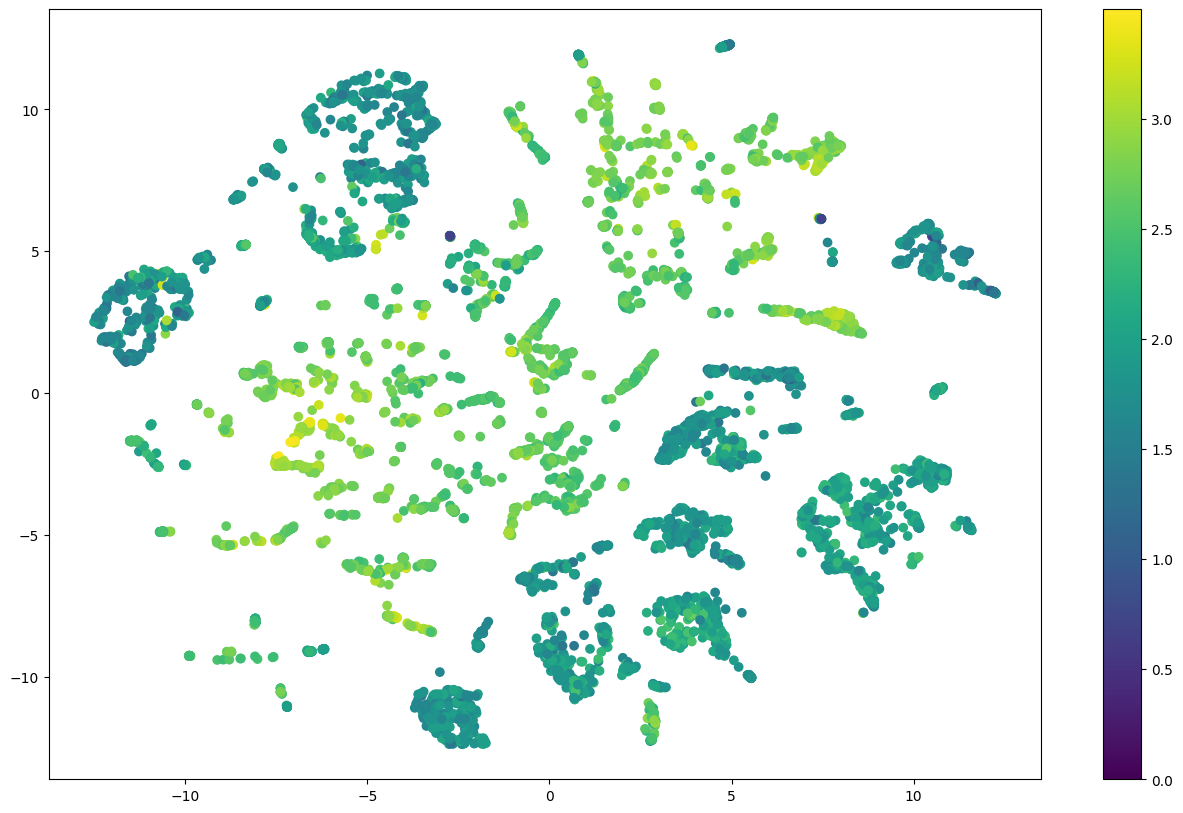

In [49]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE 모델 정의 (n_components는 출력 차원, 여기서는 2D)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

# t-SNE를 사용하여 차원 축소
tsne_results = tsne.fit_transform(X[:10000])  # 예시로 처음 10000개 샘플만 사용

# 결과 시각화
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y[:10000], cmap='viridis')
plt.colorbar(scatter)
plt.show()

# 중요한것만으로 한다면?

In [51]:
def get_neuron_ordering_for_linear_regression(probe, search_stride=100):
    """
    Get neuron ordering for a specific class from a trained probe.

    Parameters
    ----------
    probe : interpretation.linear_probe.LinearProbe
        Trained probe model
    search_stride : int, optional
        Number of steps to divide the weight mass percentage

    Returns
    -------
    neuron_ordering : numpy.ndarray
        Array of neurons ordered by their importance for the specified class
    """
    # class_idx = class_to_idx[class_name]
    weights = list(probe.parameters())[0].data.cpu().numpy()
    abs_weights = np.abs(weights[0])

    neuron_orderings = []
    for p in range(1, search_stride + 1):
        percentage = p / search_stride
        total_mass = np.sum(abs_weights)
        sorted_idx = np.argsort(abs_weights)[::-1]  # Sort in descending order
        cum_sums = np.cumsum(abs_weights[sorted_idx])
        selected_neurons = sorted_idx[cum_sums <= total_mass * percentage]
        neuron_orderings.extend(selected_neurons)

    # Remove duplicates while preserving order
    neuron_ordering = list(dict.fromkeys(neuron_orderings))

    return np.array(neuron_ordering)

# load pre-trained probe
probe = linear_probe.LinearProbe(X.shape[1], 1)
probe.load_state_dict(
    torch.load(os.path.join(log_dir, 'models', 'probe.pth')))
ordering = get_neuron_ordering_for_linear_regression(probe)

In [56]:
X_selected = ablation.filter_activations_keep_neurons(X, ordering[:100])

/home/dahye/anaconda3/envs/ttsxai/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/dahye/anaconda3/envs/ttsxai/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.489s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.406398
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.650459
[t-SNE] KL divergence after 300 iterations: 2.045171


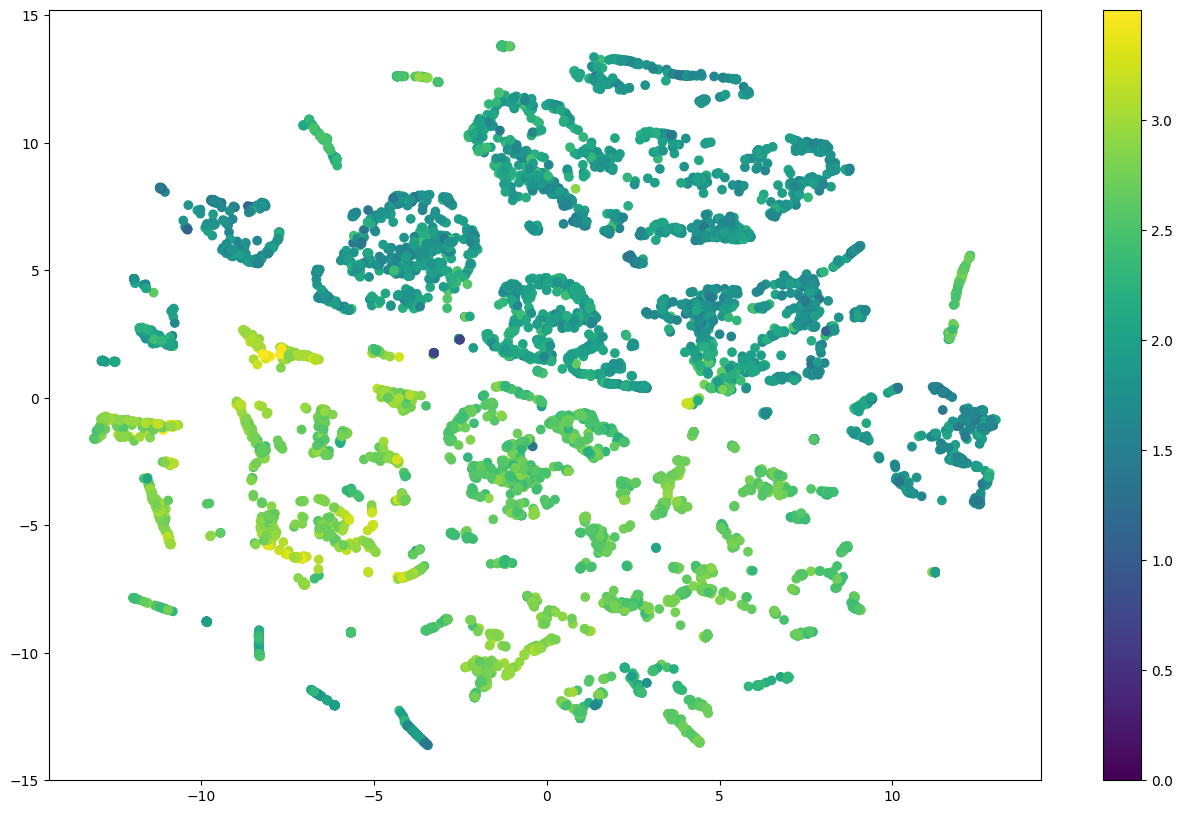

In [57]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE 모델 정의 (n_components는 출력 차원, 여기서는 2D)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

# t-SNE를 사용하여 차원 축소
tsne_results = tsne.fit_transform(X_selected[:10000])  # 예시로 처음 10000개 샘플만 사용

# 결과 시각화
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y[:10000], cmap='viridis')
plt.colorbar(scatter)
plt.show()